In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Data SO2 Preparation

In [2]:
# Total SO2 preparation
# Load CSV
df_csv = pd.read_csv('/Users/Jia/Downloads/data_skripsi/SO_2/so2_arrange.csv')

In [3]:
# Mengonversi kolom 'time' ke tipe data datetime
df_csv['time'] = pd.to_datetime(df_csv['time'])

# Menambahkan kolom 'month'
df_csv['month'] = df_csv['time'].dt.month

# Menambahkan kolom 'year'
df_csv['year'] = df_csv['time'].dt.year

# Melakukan group by bulan, longitude, dan latitude, dan menghitung rata-rata so2
so2_mean_monthly = df_csv.groupby(['month', 'year', 'longitude', 'latitude'], as_index=False)['so2'].mean()

Optional

Menyimpan hasil ke file CSV #

df_csv.to_csv('/Users/Jia/Downloads/data_skripsi/SO_2/so2_mean_month.csv', index=False)

Spatial Join df and gdf

In [4]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/Jia/Downloads/data_skripsi/kota_DKIJakarta/Kota_DKIJakarta.shp")

In [5]:
# Convert DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df_csv['longitude'], df_csv['latitude'])
gdf_csv = gpd.GeoDataFrame(df_csv, geometry=geometry, crs="EPSG:4326")

<Axes: >

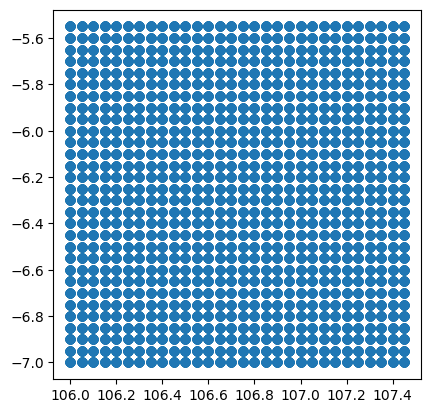

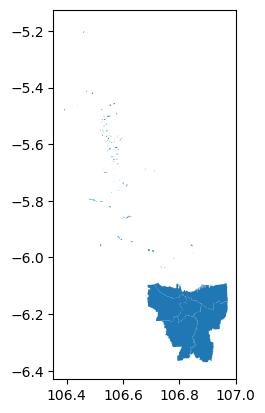

In [6]:
gdf_csv.plot()
gdf_shapefile.plot()

In [7]:
# spatial join
result = gpd.sjoin(gdf_csv, gdf_shapefile, how='inner', predicate='intersects')
result_pop = result[['longitude', 'latitude', 'so2', 'month', 'year', 'KABKOT', 'geometry', 'time']]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1440 entries, 406 to 53659
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  1440 non-null   float64       
 1   latitude   1440 non-null   float64       
 2   so2        1440 non-null   float64       
 3   month      1440 non-null   int32         
 4   year       1440 non-null   int32         
 5   KABKOT     1440 non-null   object        
 6   geometry   1440 non-null   geometry      
 7   time       1440 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(1), int32(2), object(1)
memory usage: 90.0+ KB


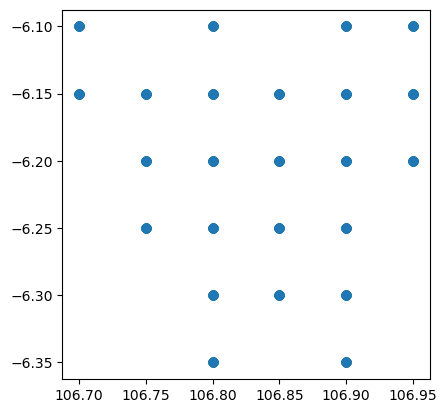

In [9]:
result_pop.plot()
result_pop.info()

Dissolved Result

In [11]:
# Dissolve berdasarkan 'KABKOT' dan 'month' dengan fungsi agregasi mean
dissolved_result = result_pop.dissolve(by=['KABKOT', 'month', 'year'], aggfunc='mean')

# Reset indeks untuk membuat kolom 'KABKOT' 'month', dan 'year' menjadi kolom
dissolved_result.reset_index(inplace=True)

In [12]:
# Tampilkan hasil
dissolved_result.head()

,KABKOT,month,year,geometry,longitude,latitude,so2,time
0,JAKARTA BARAT,1,2018,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,63.577458,2018-01-01
1,JAKARTA BARAT,1,2019,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,73.500805,2019-01-01
2,JAKARTA BARAT,1,2020,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,75.285376,2020-01-01
3,JAKARTA BARAT,1,2021,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,75.220695,2021-01-01
4,JAKARTA BARAT,1,2022,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,78.397712,2022-01-01


In [13]:
dissolved_result_df = pd.DataFrame(dissolved_result)
dissolved_result_df = dissolved_result_df.drop(['geometry'], axis=1) #kolom geometry di hapus

In [14]:
#untuk mengurutkan file berdasarkan
dissolved_result_df = dissolved_result_df.sort_values(by=[ 'year', 'KABKOT', 'month'])

In [15]:
dissolved_result_df.to_csv("/Users/Jia/Downloads/data_skripsi/SO_2/dissolved_result_so2.csv") 

#di save ke csv, jadi data rata" bulanan

In [16]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')
polygon_result.rename(columns= {'KABKOT_left':'KABKOT', 'index_right':'index'}, inplace=True)
polygon_result.drop(columns={'KABKOT_right'}, inplace=True)

In [17]:
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT', 'geometry', 'index',
       'month', 'year', 'longitude', 'latitude', 'so2', 'time'],
      dtype='object')


Grafik Timetrend Series

In [18]:
import calendar

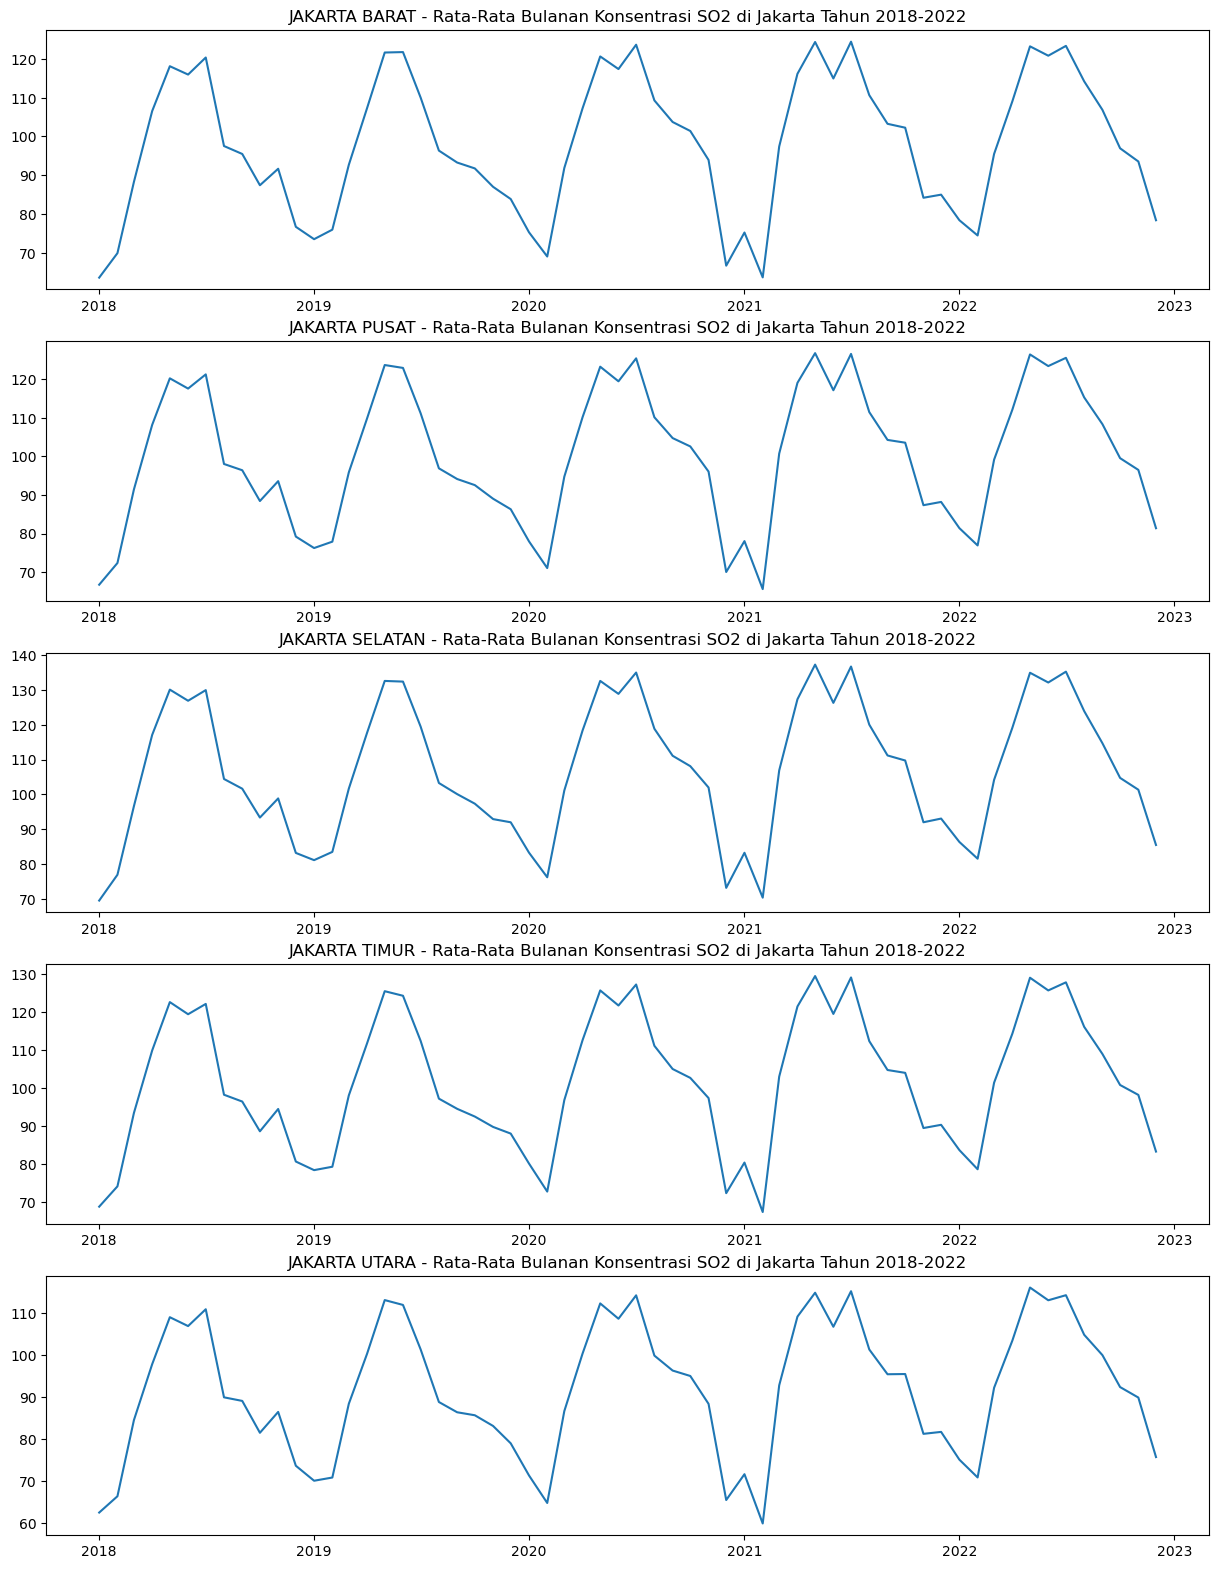

In [19]:
fig  = plt.figure(figsize=(15,60))
cities = list(dissolved_result_df['KABKOT'].unique())
dissolved_result_df = dissolved_result_df.set_index('time')

# Iterate through each month and plot the data
for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
    fig.add_subplot(15, 1, ax)
    plt.plot(data_city['so2'])
    plt.title(f'{city} - Rata-Rata Bulanan Konsentrasi SO2 di Jakarta Tahun 2018-2022')
    #ax.set_title(f'{city}')

Analisis Univariat

In [20]:
mean_so2_month_year = dissolved_result.groupby(['year', 'month'], as_index=False)['so2'].mean()

mean_so2_month_year['so2'] = mean_so2_month_year['so2'].round(2)

mean_so2_month_year

,year,month,so2
0,2018,1,66.26
1,2018,2,71.97
2,2018,3,90.88
3,2018,4,107.91
4,2018,5,120.01
5,2018,6,117.35
6,2018,7,120.92
7,2018,8,97.65
8,2018,9,95.83
9,2018,10,87.88


In [21]:
#mean_so2_month_year.to_excel("/Users/Jia/Downloads/data_skripsi/SO_2/so2_year_mean.xlsx")

In [22]:
# mean per tahun
so2_year_mean = dissolved_result.groupby(['year'], as_index=False)['so2'].mean()

so2_year_mean['so2'] = so2_year_mean['so2'].round(2)

so2_year_mean

,year,so2
0,2018,95.70
1,2019,97.62
2,2020,100.07
3,2021,102.03
4,2022,103.35


In [23]:
#nilai mean
so2_mean_5years = mean_so2_month_year ['so2'].mean()
so2_mean_5years

99.75183333333332

In [25]:
#nilai min
so2_min_5years = mean_so2_month_year ['so2'].min()
so2_min_5years

65.41

In [26]:
#nilai max
so2_max_5years = mean_so2_month_year ['so2'].max()
so2_max_5years

126.54

In [27]:
# nilai min and max per kabkot 5 tahun
monthly_total = dissolved_result_df.groupby(['KABKOT', 'month'], as_index=False)['so2'].mean()

monthly_total['so2'] = monthly_total['so2'].round(2)

# Nilai minimum
min_row = monthly_total.loc[monthly_total['so2'].idxmin()]
min_location = min_row['KABKOT']
min_month = min_row['month']
min_value = min_row['so2']

# Nilai maksimum
max_row = monthly_total.loc[monthly_total['so2'].idxmax()]
max_location = max_row['KABKOT']
max_month = max_row['month']
max_value = max_row['so2']

# Menampilkan hasil
print(f"SO2 min = {min_value}, {min_location}, {min_month}.")
print(f"SO2 max = {max_value},{max_location}, {max_month}.")

SO2 min = 66.6, JAKARTA UTARA, 2.
SO2 max = 133.44,JAKARTA SELATAN, 5.


In [28]:
#mean kabkot 5 years

mean_kabkot = dissolved_result_df.groupby(['KABKOT'], as_index=False)['so2'].mean()

mean_kabkot['so2'] = mean_kabkot['so2'].round(2)

mean_kabkot_sorted = mean_kabkot.sort_values(by='so2', ascending=False)
print(mean_kabkot_sorted)

            KABKOT     so2
2  JAKARTA SELATAN  106.81
3    JAKARTA TIMUR  101.79
1    JAKARTA PUSAT  100.15
0    JAKARTA BARAT   98.06
4    JAKARTA UTARA   91.94
